# Demo for Overlandflow Simulation

## Import packages

In [1]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from IPython.display import Video

from flood_simulator import FloodSimulator

## Set Parameters

In [2]:
# terrain info
terrain = {
    "grid_file": "geer_canyon.txt",  # DEM file name (ASCII format)
    "nodata_value": -9999,  # nodata value in the DEM file
    "outlet_id": -1  # set as -1 if outlet id number is unknown
}

In [3]:
# output setting
output = {
    "output_folder" : "output",  # output folder name
    "plot_olf": True,  # plot overland flow results
    "plot_inf": True   # plot infiltration results
}

In [4]:
# model run setting
model_run = {
    "model_run_time": 200,  # min
    "storm_duration": 10,  # min
    "time_step": 2,  # min  set the time step to create the plot result
    "activate_inf":  True ,#  set as true to enable infiltration process
}

In [5]:
# overland flow setting
olf_info = {
    "rain_file": '',  # set as '' if no file exist, mm/hr
    "rain_intensity": 59.2,  # mm/hr
    "surface_water_file": '',  # set as '' if no file exist, m
    "surface_water_depth": 1e-12,  # m
    "steep_slopes": True,
    "alpha": 0.7,  # time step coefficient
    "mannings_n": 0.03,  # manning's roughness coefficient
    "g": 9.80665,  # acceleration due to gravity m/s^2
    "theta": 0.8   # wighting factor
}

# TODO: assign different rain intensity scenario for real case (2013, 2021) using observation data and rain intensity map

In [6]:
# infiltration setting
infil_info = {
    "conductivity_file": "",  # m/s, set as '' if no file exist
    "hydraulic_conductivity": 1.0e-7,  # m/s
    "soil_water_file": '',  # m, set as '' if no file exist
    "soil_water_infiltration_depth": 1e-5,  # m
    "soil_bulk_density": 1590.0,  # kg/m3
    "rock_density": 2650.0,  # kg/m3
    "initial_soil_moisture_content": 0.15, # [0-1]
    "soil_type": "sandy loam",
    "volume_fraction_coarse_fragments": 0.2,  # [0-1]
    "coarse_sed_flag": False,
    "surface_water_minimum_depth": 1.0e-8,   # m
    "soil_pore_size_distribution_index": False,
    "soil_bubbling_pressure": False,  # m
    "wetting_front_capillary_pressure_head": False,  # m
}

# supported soil type:
# 'sand', loamy sand', 'sandy loam', 'loam', 'silt loam', 'sandy clay loam',
# 'clay loam', 'silty clay loam', 'sandy clay', 'silty clay', 'clay'

## Input DEM 

Text(0, 0.5, 'Y')

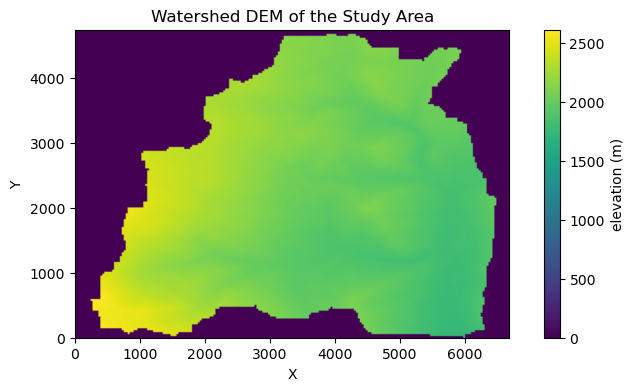

In [7]:
# Load DEM file 
with rasterio.open(terrain["grid_file"]) as dataset:
    # Read the first band
    dem_data = dataset.read(1)

    # Get metadata (optional)
    extent = [dataset.bounds.left, dataset.bounds.right, dataset.bounds.bottom, dataset.bounds.top]

# Plot the raster
plt.figure(figsize=(9, 4))
plt.imshow(dem_data, cmap="viridis", extent=extent, vmin=0)
plt.colorbar(label="elevation (m)")
plt.title("Watershed DEM of the Study Area")
plt.xlabel("X")
plt.ylabel("Y")

## Input Hydraulic Conductivity: Based on Fire Map  (for Geer canyon)
If you would like to experiment with a spatially varied hydraulic conductivity input based on the fire map, run the cells below; otherwise, skip to the "Run Model" section.

Text(0, 0.5, 'Y')

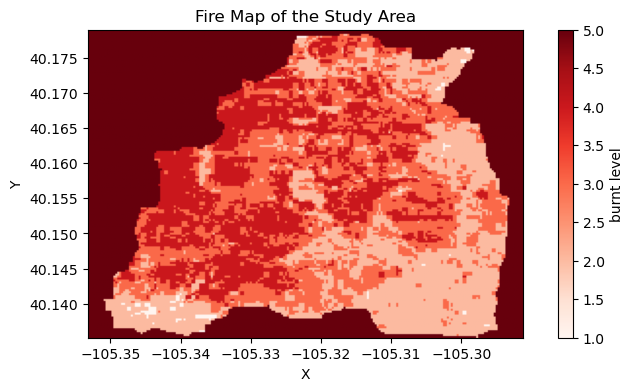

In [8]:
# Load fire map file
fire_map = "fire_map_geercanyon.tif"

with rasterio.open(fire_map) as dataset:
    # Read the first band
    fire_data = dataset.read(1)

    # Get metadata (optional)
    extent = [dataset.bounds.left, dataset.bounds.right, dataset.bounds.bottom, dataset.bounds.top]

# Plot the raster
plt.figure(figsize=(9, 4))
plt.imshow(fire_data, cmap="Reds", extent=extent, vmin=1, vmax=5)
plt.colorbar(label="burnt level")
plt.title("Fire Map of the Study Area")
plt.xlabel("X")
plt.ylabel("Y")

In [9]:
# update the infiltration parameter setting

infil_info["conductivity_file"] = "hydr_cond_geercanyon.tif"

# 1 - 4 represents the burning level in the fire map
# hydraulic conductivity default value as 1.0e-7 m/s

# At this stage, we arbitrarily enter the values. You can try with other values.
mapping_table = {
    1 : 1.0e-7,  # "Unburned"
    2 : 0.9e-7,  # "Low severity"
    3 : 0.6e-7,  # "Moderate"
    4 : 0.4e-7,  # "High"
}

In [10]:
# create hydraulic conductivity file
with rasterio.open(fire_map) as src:
    data = src.read(1)
    profile = src.profile.copy()
    
profile.update(dtype='float32')
new_data = data.copy().astype("float32")
for level, value in mapping_table.items():
    new_data = np.where(data==level, value, new_data)
    if level == 1:
        new_data = np.where(data==255, value, new_data)

with rasterio.open(infil_info["conductivity_file"], "w", **profile) as dst:
    dst.write(new_data, 1)

Text(0, 0.5, 'Y')

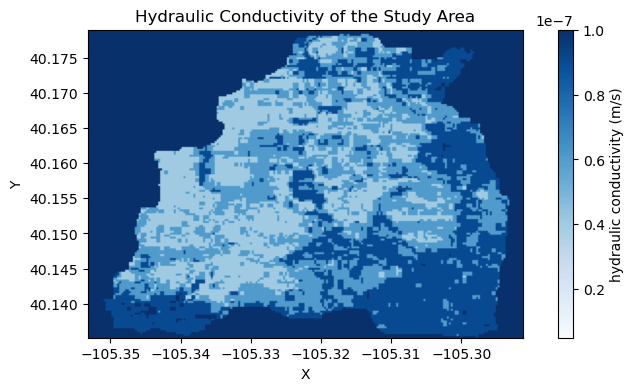

In [11]:
# plot hydraulic conductivity data
with rasterio.open(infil_info["conductivity_file"]) as dataset:
    # Read the first band
    hydr_cond_data = dataset.read(1)

    # Get metadata (optional)
    extent = [dataset.bounds.left, dataset.bounds.right, dataset.bounds.bottom, dataset.bounds.top]
    
plt.figure(figsize=(9, 4))
plt.imshow(hydr_cond_data, cmap="Blues", extent=extent, vmin=0.5e-8, vmax=1e-7)
plt.colorbar(label="hydraulic conductivity (m/s)")
plt.title("Hydraulic Conductivity of the Study Area")
plt.xlabel("X")
plt.ylabel("Y")

# Run Model

In [12]:
fs = FloodSimulator(terrain, output, model_run, infil_info, olf_info)

In [13]:
fs.run()

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.85it/s]


## Show Results

In [14]:
# # Make a short video
results_dir = os.path.join(os.getcwd(), output["output_folder"])
for name in ['flow','infil']:
    img_files = [
        os.path.join(results_dir, file)
        for file in os.listdir(results_dir)
        if name in file and ".png" in file
    ]
    img_files.sort(key=lambda x: os.path.getmtime(x))
    
    with imageio.get_writer(
        os.path.join(results_dir, f"{name}.mp4"), mode="I", fps=10, macro_block_size=1
    ) as writer:
        for f in img_files:
            im = imageio.imread(os.path.join(results_dir, f))
            writer.append_data(im)
    
    writer.close()

In [15]:
# Display the overland flow results
Video(os.path.join(output["output_folder"], "flow.mp4"), embed=True, width=900, height=700)

In [16]:
# Display the infiltration results
Video(os.path.join(output["output_folder"], "infil.mp4"), embed=True, width=900, height=700)